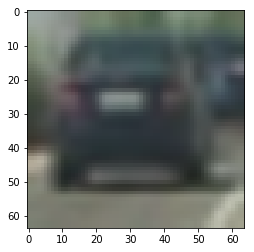

Sample Car shape (64, 64, 3)
Number of Car samples 8792
Number of Non Car samples 8968


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
 
    
# Read in cars and notcars
images_v = glob.glob('vehicles/*/*.png')
images_nv = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []
for image in images_nv:
    notcars.append(image)
    
for image in images_v:
    cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = len(cars)
cars = cars[0:sample_size]
sample_size = len(cars)
img=mpimg.imread(cars[0])
plt.imshow(img)
plt.show()
print("Sample Car shape", img.shape)
print("Number of Car samples", len(cars))
print("Number of Non Car samples", len(notcars))
notcars = notcars[0:sample_size]




In [2]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    


In [3]:
svc = LinearSVC()
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
t1=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2=time.time()
print("Feature extraction time:", t2-t1)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


Feature extraction time: 71.55219984054565
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
21.26 Seconds to train SVC...


In [4]:
result=svc.predict(X_train)
acc = np.sum(result==y_train)*1.0/y_train.shape
#print(result, y_train, acc)
print("Train accuracy:", acc)
result=svc.predict(X_test)
acc = np.sum(result==y_test)*1.0/y_test.shape
#print(result, y_train, acc)
print("Test accuracy:", acc)

Train accuracy: [ 1.]
Test accuracy: [ 0.98947967]


In [10]:
#8 2 (32, 32) 32
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    imshape = ctrans_tosearch.shape
    if scale != 1:
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    #print(imshape)
    #print(ctrans_tosearch.shape)
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window)// cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
# 7*7*4*9 = 1764    
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
#(256, 1280, 3)
#(170, 853, 3)
#49 6 105 20
    box_list=[]
    #print(nxsteps,nysteps,nxblocks, nyblocks)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print(len(spatial_features), len(hist_features), len(hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return box_list

def draw_box_list(img, box_list):
    #draw_img = np.zeros_like(img) 
    draw_img = np.copy(img)
    for box in box_list:
        cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 

    return draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    img1=np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img1, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img1

def process_img(img):
    ystart = 400
    ystop = 656
    box_list = []
    for scale in [0.75, 1.5, 2]:
        box1= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list +=box1
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    #print("Max heat",np.max(heatmap))
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [6]:
#Helper functions
def gray2rgb(img):
    return np.dstack(( img, img, img))

def plt_img(img,file):
    plt.figure()
    plt.hist(img.flatten(),256,[0,256], color = 'b')   
    plt.xlim([0,256])   
    plt.legend(('histogram'), loc = 'upper left')   
    plt.savefig(file+"_hist.png")

def draw_box(img, src):
    clr=[255,255,255]
    #clr=[0,0,0]
    for j in range(4):
        cv2.line(img, src[j],src[(j+1)%4],  color=clr,thickness=4)
    
def camera_init():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return mtx, dist

# Edit this function to create your own pipeline.
def binary_pipeline(img, img_mask, l_thresh=(100, 255),s_thresh=(100, 255),\
                    sx_thresh=(20, 100), \
                    sa_thresh=(0.7,1.3),\
                    sm_thresh=(30, 100)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    gray1=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray1,(5,5),0)
    #gray = gray1
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sx = np.absolute(sx)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sy = np.absolute(sy)
    s=np.arctan2(sy, sx)
    abinary=np.zeros_like(s)
    thresh_max=sa_thresh[1]
    thresh_min=sa_thresh[0]
    abinary[(s<=thresh_max) & (s>=thresh_min) ]=1    
    
    s2=np.sqrt(sy**2+sx**2)
    mbinary=np.zeros_like(s2)
    thresh2_max=sm_thresh[1]
    thresh2_min=sm_thresh[0]
    mbinary[(s2<=thresh2_max) & (s2>=thresh2_min) & (s<=thresh_max) & (s>=thresh_min)]=1 
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])              ] = 1
    
    l_binary = np.zeros_like(gray)
    l_binary[(gray >= l_thresh[0])& (img_mask==1) & (gray <= l_thresh[1])              ] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( s_binary, sxbinary, l_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(l_binary == 1)  & ((s_binary == 1) | (sxbinary==1))] = 255
    combined_binary = np.dstack((combined_binary,combined_binary,combined_binary))
    return color_binary, combined_binary
# Edit this function to create your own pipeline.

def binary2_pipeline(img, l_thresh=(120, 255), s_thresh=(120, 255)):
    gray1=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray1,(5,5),0)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])              ] = 1
    
    l_binary = np.zeros_like(gray)
    l_binary[(gray >= l_thresh[0]) & (gray <= l_thresh[1])              ] = 1
    kernel = np.ones((5,5),np.uint8)
    l_binary = cv2.erode(l_binary, kernel, iterations=1)
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(l_binary == 1) | (s_binary == 1)] = 1
    return combined_binary

def get_warp_M(rows, cols, adj_x=0, adj_y=0):
    offsetx=300
    #offsetx=150
    offsetx1=offsetx
    offsetx2=offsetx
    offsety=2
    src=[(250-adj_x,673),(1030-adj_x,673),(665-adj_x,436-adj_y),(615-adj_x,436-adj_y)]
#    src=[(268-adj_x,673),(1035-adj_x,673),(667-adj_x,436-adj_y),(615-adj_x,436-adj_y)]
#    dst=[(offsetx1,rows-offsety),(cols-offsetx2,rows-offsety),(cols-offsetx2,1),(offsetx1,1)]
    dst=[(250,rows-offsety),(1030,rows-offsety),(1030,1),(250,1)]
    M=cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    Minv=cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    return M, Minv,src


def warp_pipeline(img, mtx, dist, M):
    rows, cols=img.shape[0:2]
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped=np.copy(undist)
    warped = cv2.warpPerspective(undist, M, (cols,rows))
    return warped



def preprocess_pipeline(img, clache=False):
    if(clache==True):
        img1 =cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
        img1[:,:,1] = clahe.apply(img1[:,:,1])
        img = cv2.cvtColor(img1, cv2.COLOR_HLS2RGB)
    return img


def pipeline_frontend(img,mtx,dist,M, preprocess=False,\
                      l_thresh=(120, 255), \
                      s_thresh=(120, 255),sx_thresh=(20, 255)):
    img = preprocess_pipeline(img, clache=preprocess)
    img1=binary2_pipeline(img,\
        l_thresh=l_thresh,
        s_thresh=s_thresh)
    img_mask = warp_pipeline(img1,mtx,dist,M)
    img2 = warp_pipeline(img,mtx,dist,M)
    img_colored, img_warped = binary_pipeline(img2,\
        img_mask,
        l_thresh=[0,255],\
        s_thresh=s_thresh,\
        sx_thresh=sx_thresh, \
        sa_thresh=(np.pi*0/8,np.pi*4.0/8.0), \
        sm_thresh=(40, 255))
    return img_warped, img_colored, img2

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),\
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def gen_inds(warped, level, window_height, margin, l_center, r_center):
    #print ("level", level)
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    win_y_low = warped.shape[0] - (level+1)*window_height
    win_y_high = warped.shape[0] - level*window_height

    leftx_current = l_center
    rightx_current = r_center
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) \
        & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) \
        & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    return good_left_inds, good_right_inds


def get_pts(warped, inds):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[inds]
    lefty = nonzeroy[inds] 
    return leftx, lefty


def find_window_centroids(warped, window_width, window_height, \
                          margin, min_pix, debug=False):
    #print("margin",margin)
    img_width=warped.shape[1]
    left_lane_inds=[]
    right_lane_inds=[]
    default_dist = 1045-365
    default_left = 365
    default_right = 1045
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(7*warped.shape[0]/8):,:int(warped.shape[1]/2)], axis=0)
    conv_l = np.convolve(window,l_sum)
    if(len(conv_l)>0):
        l_center = np.argmax(conv_l)-window_width/2
        l_max = np.max(conv_l)
    else:
        l_center = default_left
        l_max = 0
    r_sum = np.sum(warped[int(7*warped.shape[0]/8):,int(warped.shape[1]/2):], axis=0)
    conv_r = np.convolve(window,r_sum)
    if(len(conv_r)>0):
        r_center = np.argmax(conv_r)-window_width/2+int(warped.shape[1]/2)
        r_max = np.max(conv_r)
    else:
        r_center = default_right
        r_max = 0
    
    dist=default_dist
    level = 0

    if(l_max>=min_pix and r_max>=min_pix):
        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))
        dist=r_center-l_center    
    elif (l_max>=min_pix):
        window_centroids.append((l_center,-1))
        dist=default_dist   
    elif (r_max>=min_pix): 
        window_centroids.append((-1,r_center))
        dist=default_dist   
    #need to add the empty window
    else:
        window_centroids.append((-1,-1))
        dist=r_center-l_center    
    #debug=True
    if(debug==True):
        print ("0:", l_max/255, l_center, r_max/255, r_center, dist)
    # Go through each layer looking for max pixel locations
    center1 = (l_center+r_center)/2
    left_dir=False
    right_dir=False
    
    for level in range(1,(int)(warped.shape[0]/window_height)):
    #for level in range(0):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        conv_l = conv_signal[l_min_index:l_max_index]
        if(len(conv_l)>0):
            l_center = np.argmax(conv_l)+l_min_index-offset
            l_max = np.max(conv_l)
            l_center = max(l_center, window_width/2)
        else:
            l_max = 0
            
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        conv_r = conv_signal[r_min_index:r_max_index]
        if(len(conv_r)>0):
            r_center = np.argmax(conv_r)+r_min_index-offset
            r_center = min(r_center,warped.shape[1]-window_width/2)
            r_max = np.max(conv_r)
        else:
            r_max = 0
        cond=0
        if(l_max>=min_pix and r_max>=min_pix):
            # Add what we found for that layer
            dist=r_center-l_center    
            window_centroids.append((l_center,r_center))
        elif (l_max>=min_pix):
            r_center = -1
            window_centroids.append((l_center,r_center))
        elif (r_max>=min_pix): 
            l_center = -1
            window_centroids.append((l_center,r_center))
        else:
            l_center = -1
            r_center = -1
            window_centroids.append((l_center,r_center))
            
        if(debug==True):
            if(cond):
                print (level, ":", l_max/255, l_center, r_max/255, r_center, dist)
            else:
                print (level, "::", l_max/255, l_center, r_max/255, r_center, dist)            
        if(l_center>=img_width/2-100 or l_center<=window_width/2):
            break
        elif(r_center<=img_width/2+100 or r_center>=img_width-window_width/2):
            break
    return window_centroids, left_lane_inds, right_lane_inds

def init_parameters():
    
    # window settings
    window_width = 100 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 120 # How much to slide left and right for searching
    min_pixel = 80*255

    return [window_width, window_height, margin, min_pixel]

def pipeline_backend_find(warped, p, debug=False):
    [window_width, window_height, margin, min_pixel]=p
    window_centroids,left_lane_inds, right_lane_inds  = \
    find_window_centroids(warped, window_width, window_height, \
                          margin, min_pixel, debug=debug)
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    l2_points = np.zeros_like(warped)
    r2_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        if(window_centroids[level][0]>0):
            l2_points[((l_mask == 1) ) ] = 255
        if(window_centroids[level][1]>0):
            r2_points[((r_mask == 1) ) ] = 255
        if(window_centroids[level][0]>0):
            l_points[(warped > 0) & ((l_mask == 1) ) ] = 255
        if(window_centroids[level][1]>0):
            r_points[(warped > 0) & ((r_mask == 1) ) ] = 255
    if len(window_centroids) > 0:
    # Color in left and right line pixels
        template1 = np.array(r_points,np.uint8) # add both left and right window pixels together
        #template1[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = 255
        template2 = np.array(l_points,np.uint8) # add both left and right window pixels together
        #template2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = 255
        zero_channel = np.zeros_like(template1) # create a zero color channel
        template = np.array(cv2.merge((template2,template1,zero_channel)),np.uint8) # make window pixels green

    else:
        template1 = np.array(r_points,np.uint8) # add both left and right window pixels together
        template = np.array(cv2.merge((template1,template1,template1)),np.uint8) # make window pixels green
        
    leftx = np.where(l_points>0)[1]    
    lefty = np.where(l_points>0)[0]    
    rightx = np.where(r_points>0)[1]    
    righty = np.where(r_points>0)[0]    
    # Fit a second order polynomial to each
    if(len(leftx)>0):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = []
    if(len(rightx)>0):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = []
    return left_fit, right_fit, template

def pipeline_backend_track(warped, left_fit, right_fit):
    margin=30
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) +\
                                left_fit[1]*nonzeroy + left_fit[2] - margin)) & \
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + \
                                   left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + \
                                right_fit[1]*nonzeroy + right_fit[2] - margin)) &\
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + \
                                    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if(len(leftx)>0):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if(len(rightx)>0):
        right_fit = np.polyfit(righty, rightx, 2)
    template1 = show_fit(left_fit, right_fit, warped.shape)
    template = np.array(cv2.merge((template1,template1,template1)),np.uint8) # make window pixels green
    
    return left_fit, right_fit, template

def line_curverad(warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Define conversions in x and y from pixels space to meters
    # 720 is only for the lane image after perspective
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center_loc = (left_fitx[warped.shape[0]-1]+right_fitx[warped.shape[0]-1])/2
    center_loc = (center_loc-640)*xm_per_pix    
    return left_curverad, right_curverad, center_loc

def plot_line_fit(warped, left_fit, right_fit):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    if(len(left_fit)>0):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        plt.plot(left_fitx, ploty, color='red')
    if(len(right_fit)>0):
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        plt.plot(right_fitx, ploty, color='green')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
def show_fit(left_fit, right_fit, shape):
    margin=30
    if(not len(left_fit)>0 or not len(right_fit)>0):
        return
    # Generate x and y values for plotting
    ploty = np.linspace(0, shape[0]-1, shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros(shape)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #print(left_line_pts, right_line_pts)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), 255)
    cv2.fillPoly(window_img, np.int_([right_line_pts]), 255)
    result = window_img
    return result

0: 2364.0 276.0 188.0 1071.0 795.0
1 :: 2100.0 286.0 620.0 1092.0 806.0
2 :: 128.0 286.0 103.0 1093.0 807.0
3 :: 0.0 -1 639.0 1191.0 807.0
[  1.95856209e-03  -2.63625492e+00   1.18923051e+03] [  1.63216060e-03  -2.36939351e+00   1.93939149e+03]
[  1.96688002e-03  -2.64717812e+00   1.19282099e+03] [  1.62544345e-03  -2.36306770e+00   1.93794873e+03]
pix: 266.831137465 307.912699419 692.747055202 0.181195346191 -0.0256800247191
meter: 83.5622389743 101.036637981 0.27880586321 0.181195346191 -0.0256800247191


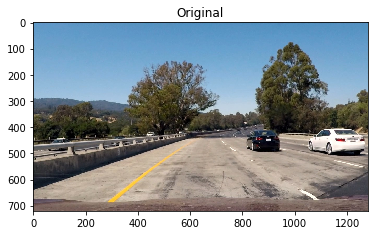

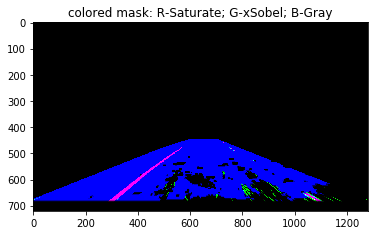

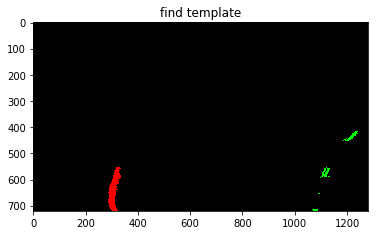

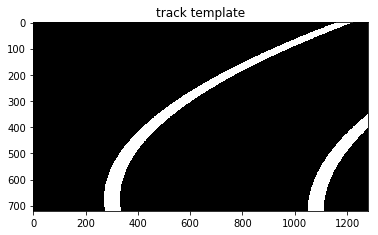

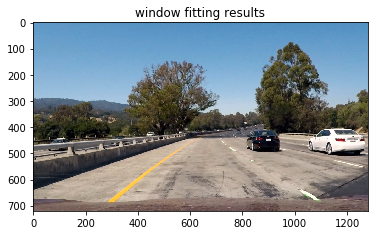

In [7]:
def test_img(img, th_param, window_params):
    [l_th, s_th, sx_th]=th_param
    warped1,colored1,_ = pipeline_frontend(img, mtx, dist,M, \
                      l_thresh=(l_th, 255), \
                      s_thresh=(s_th, 255),sx_thresh=(sx_th, 255)
                                       )
    colored = cv2.warpPerspective(colored1, Minv, (colored1.shape[1], colored1.shape[0]))         
    #colored2= cv2.addWeighted(img, 0.5, colored, 0.8, 0.0) # overlay the orignal road image with window results
    warped = warped1[:,:,0]
    left_fit,right_fit,t1=pipeline_backend_find(warped, window_params, debug=True)
    print(left_fit, right_fit)
    if(len(left_fit)>0 and len(right_fit)>0):
        pass
    else:
        print("can not fit")
        return
    left_fit,right_fit,t2=pipeline_backend_track(warped, left_fit, right_fit)
    print(left_fit, right_fit)
    t=t1
    #t = t2

    l_rad,r_rad,center_pos,k_left,k_right=get_curve(warped1,left_fit,right_fit)
    print("pix:",l_rad, r_rad, center_pos,k_left,k_right)

    l_rad, r_rad, center_pos = line_curverad(img, left_fit, right_fit)
    print("meter:",l_rad, r_rad, center_pos,k_left,k_right)
    
    t = cv2.warpPerspective(t, Minv, (t.shape[1], t.shape[0]))         
    output = cv2.addWeighted(img, 1, t, 0.3, 0.0) # overlay the orignal road image with window results

    #output=test_window_fitting(img, debug=True)
    # Display the final results
    plt.imshow(img)
    plt.title('Original')
    plt.show()
    plt.imshow(colored)
    plt.title('colored mask: R-Saturate; G-xSobel; B-Gray')
    plt.show()
    
    plt.imshow(t1)
    plt.title('find template')
    plt.show() 
    
    plt.imshow(t2)
    plt.title('track template')
    plt.show() 
    
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show() 
    
def test_fit(img,th_param, window_params):
    [l_th, s_th, sx_th]=th_param
    warped1,colored1 = pipeline_frontend(img, mtx, dist,M, \
                      l_thresh=(l_th, 255), \
                      s_thresh=(s_th, 255),sx_thresh=(sx_th, 255)
                                       )
    warped = warped1[:,:,0]
    colored = cv2.warpPerspective(colored1, Minv, (colored1.shape[1], colored1.shape[0]))         
    #colored2= cv2.addWeighted(img, 0.5, colored, 0.8, 0.0) # overlay the orignal road image with window results
    left_fit,right_fit,t=pipeline_backend_find(warped, window_params, debug=True)
    if(not len(left_fit)>0 or not len(right_fit)>0):
        print("Can not fit both lanes")
        return
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    #print(left_line_pts, right_line_pts)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    newwarp = cv2.warpPerspective(result, Minv, (result.shape[1], result.shape[0])) 
    plt.imshow(newwarp)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center_loc = (left_fitx[warped.shape[0]-1]+right_fitx[warped.shape[0]-1])/2
    print("Left/Right curvature:", left_curverad, right_curverad)
    #rint(left_fit, right_fit)
    print("Left/Right (pix):",left_fitx[warped.shape[0]-1], right_fitx[warped.shape[0]-1])
    print ("Center (pix)", center_loc)
    
def get_curve(warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    ypos=warped.shape[0]-1
    left_k= 2*ypos*left_fit[0]+left_fit[1]
    right_k= 2*ypos*right_fit[0]+right_fit[1]
    ypos=673
    ypos=720-1
    center_loc = (left_fitx[ypos]+right_fitx[ypos])/2
    return left_curverad, right_curverad, center_loc, left_k, right_k
mtx,dist=camera_init()
th_par=[140,180,40]
window_params = init_parameters()
M,Minv,src_point=get_warp_M(720,1280,adj_x=0,adj_y=0)
img = mpimg.imread('test_images/test1.jpg')
test_img(img,th_par, window_params)


8 2 (32, 32) 32
(14067, 8460)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Scale: 0.5
Scale: 1.5
Scale: 2


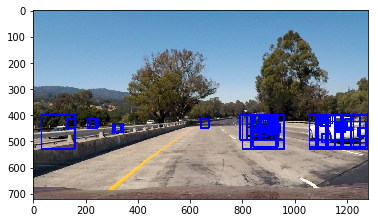

In [11]:
print(pix_per_cell, cell_per_block, spatial_size, hist_bins)
img = mpimg.imread('test_images/test1.jpg')


ystart = 400
ystop = 656

print(X_train.shape)
print(svc)

box_list = []
for scale in [0.5, 1.5, 2]:
    print("Scale:", scale)
    box1= find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #print ("Box info:", box1)
    box_list +=box1
out_img=draw_box_list(img, box_list)
plt.imshow(out_img)
plt.show()

    
    

Max heat 15.0
Total detected cars: 2


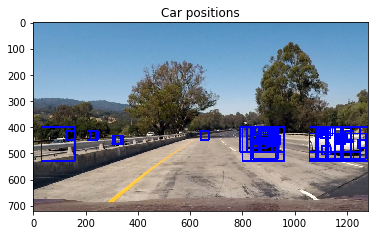

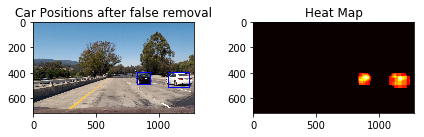

In [12]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
print("Max heat",np.max(heatmap))
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
print("Total detected cars:", labels[1])
fig = plt.figure()
plt.title('Car positions')
plt.imshow(out_img)
plt.show()
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions after false removal')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

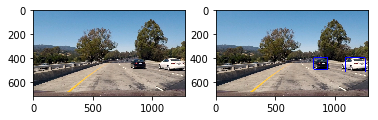

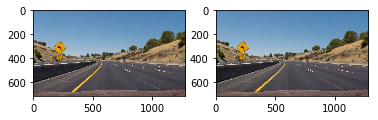

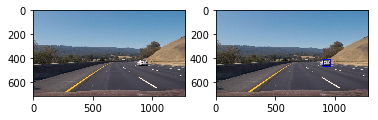

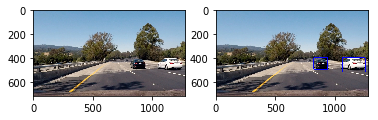

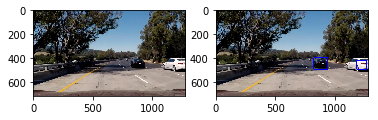

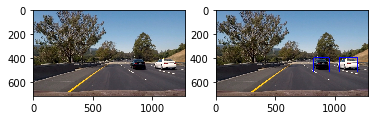

In [13]:
images_v = glob.glob('test_images/*.jpg')
for i in images_v:
    img=mpimg.imread(i)
    draw_img=process_img(img)
    plt.figure()
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(draw_img)
    fig.tight_layout()
    plt.show()

In [14]:
# Camera class, generate the camara matrix  
class Camera():
    def __init__(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('./camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)
        ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img.shape[0:2], None, None)

## Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, seq):
        self.camera1=Camera()
        self.mtx=self.camera1.mtx
        self.dist=self.camera1.dist
        # was the line detected in the last iteration?
        self.detected_left = False  
        self.detected_right = False  
        self.detected = False  
        #difference in fit coefficients between last and new fits
        self.diff_right = [0,0,0] 
        self.diff_left = [0,0,0] 
        self.left_fit=None
        self.right_fit=None
        self.frame_no=0
        # default IIR filter coefficient, confidence level of current information
        # 0 means not used totally
        self.alpha=0.3
        self.M,self.Minv,_=get_warp_M(720,1280)
        
        #radius of curvature of the line in some units
        self.left_curverad=0
        self.right_curverad=0
        #distance in meters of vehicle center from the line
        self.center_loc = 640 
        self.center_pix = 640
        self.lane_img = None
        self.color_mask = None
        self.t_img=None
        self.par=init_parameters()
        self.reset_par=False
        self.abnormal=False
        self.preprocess=False
        if(seq==0):
            self.alpha=0.3
            self.l_th=70
            self.s_th=150
            self.sx_th=40
        elif (seq==1):
            self.alpha=0.3
            self.l_th=120
            self.s_th=100
            self.sx_th=40
        else:
            self.alpha=0.3
            self.l_th=100
            self.s_th=180
            self.sx_th=40
            self.preprocess=True
        self.use_track=True
        #print("Detected:", self.detected)
    
    def change_margin_para(self,val):
        #[window_width, window_height, margin, min_pixel]
        self.par[2]=val

    def change_pix_para(self,val):
        #[window_width, window_height, margin, min_pixel]
        self.par[3]=val

    def change_par(self, val):
        [window_width, window_height, margin, min_pixel]=val
        self.par=[window_width, window_height, margin, min_pixel]
        
    def change_th(self,val):
        self.l_th=val[0]
        self.s_th=val[1]
        self.sx_th=val[2]
        
    def disp_line_info(self,undist):
        font = cv2.FONT_HERSHEY_SIMPLEX 
        color = (255,255,255)
        if(self.abnormal==True):
            track_text = 'Detecting...' 
            cv2.putText(undist, track_text, (500, 30), font, 1, color, 2) 
            return
        if(self.detected_left==False):
            track_text = 'L Not Detected' 
            cv2.putText(undist, track_text, (500, 30), font, 1, color, 2) 
        if(self.detected_right==False):
            track_text = 'R Not Detected' 
            cv2.putText(undist, track_text, (500, 60), font, 1, color, 2) 

        curvature_text = 'Left  RAD: {:.2f} m'.format(self.left_curverad)
        cv2.putText(undist, curvature_text, (900, 30), font, 1, color, 2) 
        curvature_text = 'Right RAD: {:.2f} m'.format(self.right_curverad) 
        cv2.putText(undist, curvature_text, (900, 60), font, 1, color, 2) 
        deviation_info = 'Frame No {:d}, Offset: {:.3f} m '.format(self.frame_no, self.center_loc) 
        cv2.putText(undist, deviation_info, (200, 700), font, 1, color, 2) 
        
    def create_thumbnail(self, img, ratio=0.5):
        small = cv2.resize(img, (0,0), fx=ratio, fy=ratio) 
        return small
     
    def overlap_img(self,img1,img2,x,y):
        output=np.copy(img1)
        sx=img2.shape[1]
        sy=img2.shape[0]
        for i in range(3):
            output[y:y+sy,x:x+sx,i]=img2[:,:,i]
        return output
    def adjust_img(self,img):
        offset=(self.center_pix-640)
        print("Offset image:", offset)
        img1=np.copy(img)
        if(offset>0):
            img1[:,0:1280-offset,0]=img[:,offset:1280,0]
            img1[:,0:1280-offset,1]=img[:,offset:1280,1]
            img1[:,0:1280-offset,2]=img[:,offset:1280,2]
        else:
            img1[:,-offset:1280,0]=img[:,0:1280+offset,0]
            img1[:,-offset:1280,1]=img[:,0:1280+offset,1]
            img1[:,-offset:1280,2]=img[:,0:1280+offset,2]
        return img1
    
    def process2_img(self,img):
        mtx=self.mtx
        dist=self.dist
        M=self.M
        Minv=self.Minv
        detected=self.detected
        warped1,colored1, warped2 = pipeline_frontend(img,mtx,dist,M,\
            preprocess=self.preprocess, \
            l_thresh=(self.l_th, 255), \
            s_thresh=(self.s_th, 255),sx_thresh=(self.sx_th, 255))
        self.lane_img=warped1
        self.color_mask=colored1
        warped = warped1[:,:,0]
        if(self.use_track==True and self.detected==True and self.reset_par==False):
            left_fit, right_fit, t = pipeline_backend_track(warped, \
                                self.left_fit, self.right_fit)
        else:
            left_fit, right_fit, t = pipeline_backend_find(warped, self.par)
        self.t_img=t
        # if first frame, just use the result
        if(self.frame_no==0 or self.reset_par==True):
            self.left_fit=left_fit
            self.right_fit=right_fit
        # check reliability of the result
        if 0:
            diff_left = np.abs(np.array(left_fit) - np.array(self.left_fit))/np.array(self.left_fit)
            left_ok = all(diff_left<1)
            diff_right = np.abs(np.array(right_fit) - np.array(self.right_fit))/np.array(self.right_fit)
            right_ok = all(diff_right<1)
                    
        self.detected_left=True
        self.detected_right=True
        # if not reliable, use the previous results
        if(len(left_fit)>0):
            alpha1=self.alpha
        else:
            alpha1=0
            self.detected_left=False
        if(len(right_fit)>0):
            alpha2=self.alpha
        else:
            alpha2=0
            self.detected_right=False
        #alpha1=1
        #alpha2=1
        self.detected=self.detected_left==True and self.detected_right==True
        #self.detected=False
        #print(self.left_fit, self.right_fit,  \
        #      alpha1,alpha2, "tracked", self.detected)
        if(len(left_fit)>0 and len(right_fit)>0):
            alpha_1 = self.alpha * 0.8
            l_rad,r_rad,center_pix,k_left,k_right=get_curve(warped,left_fit,right_fit)
            #self.center_pix=int((1-alpha_1)*self.center_pix + alpha_1 * center_pix)
            #offset=-self.center_pix+640
            #self.M,self.Minv,src_point=get_warp_M(720,1280,adj_x=offset,adj_y=0)

        if(len(left_fit)>0):
            #update the fit coefficnets            
            self.left_fit=[(1-alpha1)*x+alpha1 * y \
                        for x,y in zip(self.left_fit,left_fit)]
            
        if(len(right_fit)>0):
            self.right_fit=[(1-alpha2)*x+alpha2 * y \
                        for x,y in zip(self.right_fit,right_fit)]
        #print(self.left_fit, self.right_fit, diff_left, diff_right, \
        #      left_ok, right_ok, alpha1,alpha2, "tracked", self.detected)
        
        # Generate x and y values for plotting
        # Recast the x and y points into usable format for cv2.fillPoly()
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        if(len(self.left_fit)>0):
            left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        if(len(self.right_fit)>0):
            right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        img=process_img(img)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        # detect vehcicles
        if(len(self.left_fit)>0 and len(self.right_fit)>0):
            pts = np.hstack((pts_left, pts_right))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
            self.left_curverad, self.right_curverad, self.center_loc = line_curverad(warped, left_fit, right_fit)    
            # if abnormal condition happens, reset all parameters.
            if(abs(self.center_loc)>0.5 or self.left_curverad<5.0 or self.left_curverad<5.0):
                self.reset_par=True
                self.abnormal=True
            else:
                self.reset_par=False
                self.abnormal=False
                
        if self.abnormal==False:
            undist_small=self.create_thumbnail(warped2, 0.2)
            undist = self.overlap_img(undist, undist_small, 10, 0)
            warped_small=self.create_thumbnail(warped1, 0.2)
            template_small=self.create_thumbnail(t, 0.2)
            color_small=self.create_thumbnail(colored1*255, 0.2)
            undist = self.overlap_img(undist, color_small, 10, 10+144)
            undist = self.overlap_img(undist, warped_small, 10, (10+144)*2)
            undist = self.overlap_img(undist, template_small, 10, (10+144)*3)
            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
            self.newwarp=newwarp

        self.disp_line_info(undist)
       
        # Combine the result with the original image

        self.frame_no+=1
        result = cv2.addWeighted(undist, 1, self.newwarp, 0.3, 0)
        return result
  

In [15]:
def test_sequence(name, frames):
    cap = cv2.VideoCapture(name)
    while(cap.isOpened()):
        ret, frame = cap.read()
        i=line1.frame_no
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        misc.imsave('new_test_images/test'+name+'_'+str(i)+'.jpg', image)
        image1 = line1.process2_img(image)
        image2 = line1.lane_img
        misc.imsave('new_output_images/test'+name+'_'+str(i)+'.jpg', image1)
        misc.imsave('new_output_images/test_lane_'+name+'_'+str(i)+'.jpg', image2)
        if(i%32==0):
            print("frame no:", i)
        if(i>frames):
            break
    cap.release()
    cv2.destroyAllWindows()
    print("Done")                      


In [16]:
from scipy import misc

line1=Line(0)
print("Luma threshold:",line1.l_th)
print("Margin", line1.par[2])
test_sequence('project_video.mp4', 3)

Luma threshold: 70
Margin 120
frame no: 0
Done


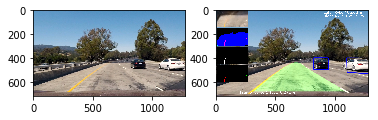

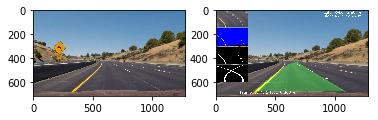

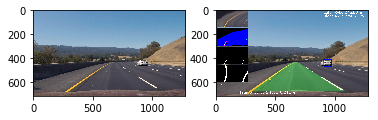

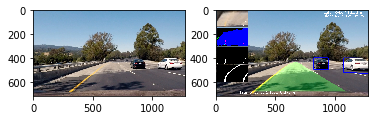

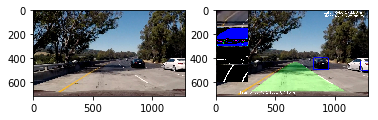

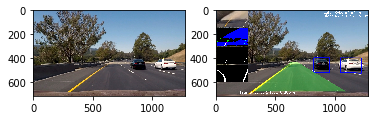

In [17]:
line1=Line(0)
images_v = glob.glob('test_images/*.jpg')
for i in images_v:
    img=mpimg.imread(i)
    draw_img=line1.process2_img(img)
    plt.figure()
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(draw_img)
    fig.tight_layout()
    plt.show()

In [18]:
input_file = './project_video.mp4'
#input_file = './test_video.mp4'
output_file = './output_project_video.mp4'
line1=Line(0)
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(line1.process2_img) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./output_project_video.mp4
[MoviePy] Writing video ./output_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [53:26<00:02,  2.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_project_video.mp4 

